In [1]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from scipy import stats

In [2]:
df = pd.read_csv('../notebooks/final_data.csv')

C:\Users\marcu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (19,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df['dt'] = pd.to_datetime(df.publishedAt)
df['comment_date'] = df.dt.dt.date

In [4]:
df['release_date_us_dt'] = pd.to_datetime(df.release_date_us)
df['upper_date_lim'] = df.release_date_us_dt + pd.Timedelta(30, "d")
df['lower_date_lim'] = df.release_date_us_dt - pd.Timedelta(30, "d")
df = df[(df.comment_date <= df.upper_date_lim) & (df.comment_date >= df.lower_date_lim)]

In [5]:
df['comment_idx'] = (pd.to_datetime(df.comment_date) - df.release_date_us_dt)
df['comment_idx'] = df.comment_idx.astype(str).str[:-5].astype(int)

In [181]:
ratings = df.groupby(['videoId', 'videoTitle', 'primaryTitle', 'averageRating']).agg(
    num_comments=('commentId', 'count')
).reset_index()
lo, hi = ratings.averageRating.quantile([.33, .66])

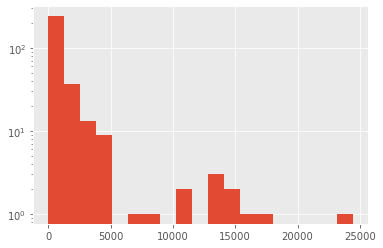

In [206]:
fig, ax = plt.subplots()

bins = np.linspace(0, ratings.num_comments.max(), 20)
ax.hist(ratings.num_comments, bins=bins)

ax.set_yscale('log')

<ipython-input-236-b63ec7331e46>:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0, y.max())


(0.6034201826036534, 24412.0)

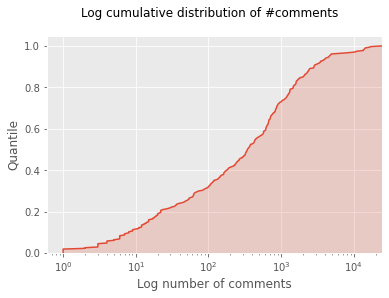

In [236]:
x = np.linspace(0, 1, 1000)
y = ratings.num_comments.quantile(x)
fig, ax = plt.subplots()
ax.plot(y, x)
ax.fill_between(y, x, alpha=.2)
ax.set_xscale('log')
fig.suptitle('Log cumulative distribution of #comments')
ax.set_xlabel('Log number of comments')
ax.set_ylabel('Quantile')

ax.set_ylim(0, 1.05)
ax.set_xlim(0, y.max())


In [237]:
fig.savefig('cumdist.svg')

In [7]:
mask_lo = df.averageRating <= lo
mask_mi = (df.averageRating > lo) & (df.averageRating <= hi)
mask_hi = df.averageRating > hi

In [175]:
df_lo = df[mask_lo]
df_mi = df[mask_mi]
df_hi = df[mask_hi]

agg_lo = df_lo.groupby(['primaryTitle', 'comment_idx']).agg(
    sentiment=('sentiment_predicted_score', 'mean'),
    comment_count=('commentId', 'count')
).reset_index()

agg_mi = df_mi.groupby(['primaryTitle', 'comment_idx']).agg(
    sentiment=('sentiment_predicted_score', 'mean'),
    comment_count=('commentId', 'count')
).reset_index()

agg_hi = df_hi.groupby(['primaryTitle', 'comment_idx']).agg(
    sentiment=('sentiment_predicted_score', 'mean'),
    comment_count=('commentId', 'count')
).reset_index()

In [176]:
agg_lo = agg_lo.groupby('comment_idx').agg(
    sentiment=('sentiment', 'median'),
    comment_count_mean=('comment_count', 'median')
).reset_index()

agg_mi = agg_mi.groupby('comment_idx').agg(
    sentiment=('sentiment', 'median'),
    comment_count_mean=('comment_count', 'median')
).reset_index()

agg_hi = agg_hi.groupby('comment_idx').agg(
    sentiment=('sentiment', 'median'),
    comment_count_mean=('comment_count', 'median')
).reset_index()

In [177]:
window = 7
trend_lo = agg_lo.rolling(window=window, center=True).mean().sentiment
trend_mi = agg_mi.rolling(window=window, center=True).mean().sentiment
trend_hi = agg_hi.rolling(window=window, center=True).mean().sentiment

In [112]:
style = plt.style.library['ggplot']
style['axes.facecolor'] = '#eaeaea'
plt.style.use(style)

In [244]:
hi_params = {
    'color': '#E24A33',
    'label': 'Over average rating'
}

mi_params = {
    'color': '#348ABD',
    'label': 'Average rating'
}

lo_params = {
    'color': '#988ED5',
    'label': 'Under average rating'
}

annot_params = {
    'color': '#777777',
    'linestyle': '--'
}

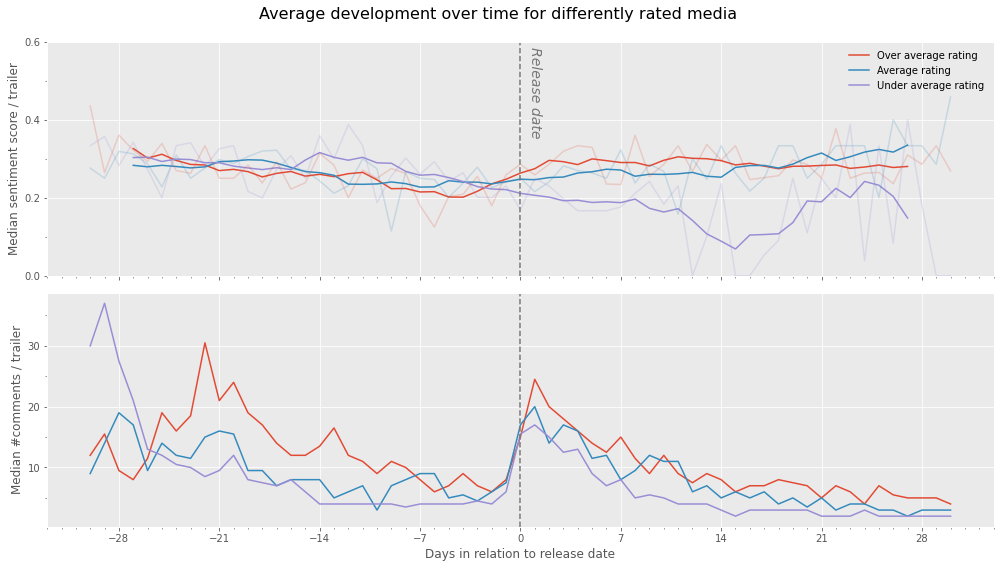

In [251]:
plt.style.use('ggplot')
fig, axes = plt.subplots(2, figsize=(14,8))

fig.suptitle('Average development over time for differently rated media ', fontsize=16)

# sentiment over time
ax = axes[0]

ax.plot(agg_hi.comment_idx, trend_hi, **hi_params)
ax.plot(agg_mi.comment_idx, trend_mi, **mi_params)
ax.plot(agg_lo.comment_idx, trend_lo, **lo_params)

ax.legend(frameon=False)

ax.plot(agg_hi.comment_idx, agg_hi.sentiment, alpha=.2, **hi_params)
ax.plot(agg_mi.comment_idx, agg_mi.sentiment, alpha=.2, **mi_params)
ax.plot(agg_lo.comment_idx, agg_lo.sentiment, alpha=.2, **lo_params)

ax.xaxis.set_major_locator(MultipleLocator(7))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(.2))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
ax.set_xticklabels([])

ax.set_ylim(0, .6)

# ax.axhline(y=0, color='k', alpha=.5)
ax.axvline(x=0, **annot_params)
ax.text(0.5, .36, 'Release date', color=annot_params['color'], fontsize=14, fontstyle='italic', rotation=-90)

ax.set_ylabel('Median sentiment score / trailer')





# count of comments over time
ax = axes[1]

ax.plot(agg_hi.comment_idx, agg_hi.comment_count_mean, **hi_params)
ax.plot(agg_mi.comment_idx, agg_mi.comment_count_mean, **mi_params)
ax.plot(agg_lo.comment_idx, agg_lo.comment_count_mean, **lo_params)

# ax.set_yscale('log')
ax.axvline(x=0, **annot_params)

ax.xaxis.set_major_locator(MultipleLocator(7))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.set_xlabel('Days in relation to release date')
ax.set_ylabel('Median #comments / trailer')


plt.tight_layout()

In [252]:
fig.savefig('dev-time-rating.svg')

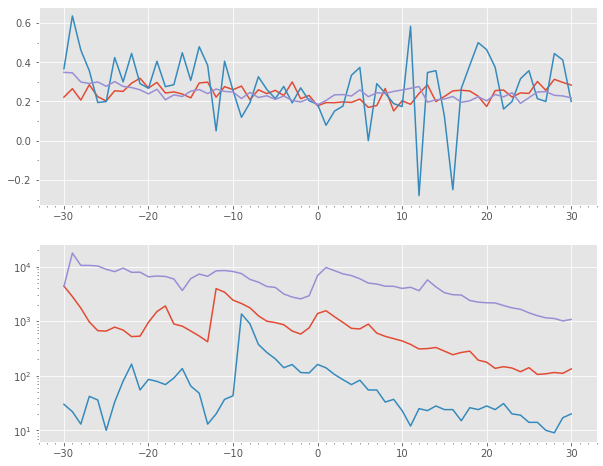

In [47]:
fig, axes = plt.subplots(2, figsize=(10,8))

networks = df.network.unique()


for network in networks:
    mask = df.network == network
    agg = df[mask].groupby('comment_idx').agg(
        sentiment=('sentiment_predicted_score', 'mean'),
        comment_count=('commentId', 'count')
    ).reset_index()
    
    ax = axes[0]
    ax.plot(agg.comment_idx, agg.sentiment)
    
    ax = axes[1]
    ax.plot(agg.comment_idx, agg.comment_count)


ax = axes[0]
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(.2))
ax.yaxis.set_minor_locator(MultipleLocator(.1))

ax = axes[1]
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_yscale('log')